# Building A Popularity-Based and Collaborative-Filtering Restaurant Recommender System


**The notebook contains the following:**
1. Exploratory Data Analysis (EDA)
2. Popularity Based Recommendation System
3. Collaborativ-Filtering Recommendation System, using the Surprise Library.

**Please do upvote, if you like the notebook :)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-data-with-consumer-ratings/chefmozcuisine.csv
/kaggle/input/restaurant-data-with-consumer-ratings/chefmozhours4.csv
/kaggle/input/restaurant-data-with-consumer-ratings/rating_final.csv
/kaggle/input/restaurant-data-with-consumer-ratings/userprofile.csv
/kaggle/input/restaurant-data-with-consumer-ratings/README
/kaggle/input/restaurant-data-with-consumer-ratings/chefmozaccepts.csv
/kaggle/input/restaurant-data-with-consumer-ratings/chefmozparking.csv
/kaggle/input/restaurant-data-with-consumer-ratings/geoplaces2.csv
/kaggle/input/restaurant-data-with-consumer-ratings/usercuisine.csv
/kaggle/input/restaurant-data-with-consumer-ratings/userpayment.csv


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate
import difflib
import random

In [3]:
# We will be using the 'rating_final.csv' file to build the recommender system
user_rating_file_path = "../input/restaurant-data-with-consumer-ratings/rating_final.csv"
geolocation_file_path = '../input/restaurant-data-with-consumer-ratings/geoplaces2.csv'

# Load the data
data = pd.read_csv(user_rating_file_path)
location_data = pd.read_csv(geolocation_file_path)

In [4]:
# Check for null values
data.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64

In [5]:
location_data.isnull().sum()

placeID           0
latitude          0
longitude         0
the_geom_meter    0
name              0
address           0
city              0
state             0
country           0
fax               0
zip               0
alcohol           0
smoking_area      0
dress_code        0
accessibility     0
price             0
url               0
Rambience         0
franchise         0
area              0
other_services    0
dtype: int64

In [6]:
data = pd.merge(data, location_data[['placeID', 'name']], on='placeID')
data = data[['userID', 'placeID' ,'name', 'rating', 'food_rating', 'service_rating']]

In [7]:
# load the first 5 rows
data.head()

,userID,placeID,name,rating,food_rating,service_rating
0,U1077,135085,Tortas Locas Hipocampo,2,2,2
1,U1108,135085,Tortas Locas Hipocampo,1,2,1
2,U1081,135085,Tortas Locas Hipocampo,1,2,1
3,U1056,135085,Tortas Locas Hipocampo,2,2,2
4,U1134,135085,Tortas Locas Hipocampo,2,1,2


# Exploratory Data Analysis

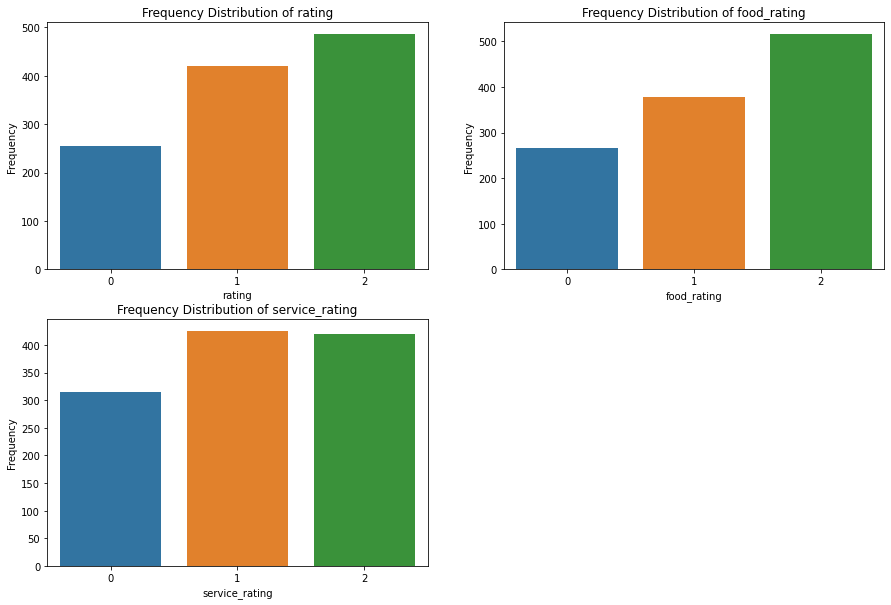

In [8]:
# Visualise the distribution of rating, food_rating and service_rating features

columns_to_plot = ['rating', 'food_rating', 'service_rating']

# Create a figure and axis for subplots

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=data, x=col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title("Frequency Distribution of {}".format(col))    
plt.show()

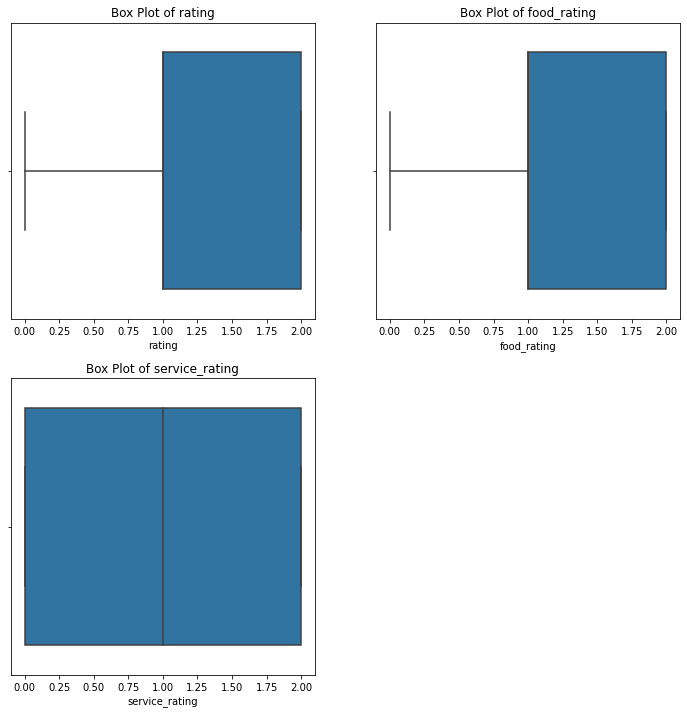

In [9]:
# plot the distribution of rating, food_rating, service_rating using boxplots
plt.figure(figsize=(12, 12))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=data, x=col)
    plt.xlabel(col)
    plt.title("Box Plot of {}".format(col))    
plt.show()

In [10]:
data.head()

'''
group the data by placeID and finding out the following:

1. Top 10 most visited restaurants (occuring the most in the data).
2. Top 10 least visited restaurants (occuring the least in the data).
3. Top 10 most rated restaurants in terms of food and service.
4. Top 10 restaurants having highest average ratings in terms of food and service.
5. Top 10 restaurants having lowest average ratings in terms of food and service.
'''

# group the data by placeID
placeID_group = data.groupby('placeID')
placeID_grouped_data = placeID_group.count().sort_values(by='rating', ascending=False)

In [11]:
# 1. Top 10 most visited restaurants
placeID_grouped_data.iloc[ : 10]

,userID,name,rating,food_rating,service_rating
placeID,,,,,
135085,36,36,36,36,36
132825,32,32,32,32,32
135032,28,28,28,28,28
135052,25,25,25,25,25
132834,25,25,25,25,25
135038,24,24,24,24,24
135060,22,22,22,22,22
135062,21,21,21,21,21
135042,20,20,20,20,20


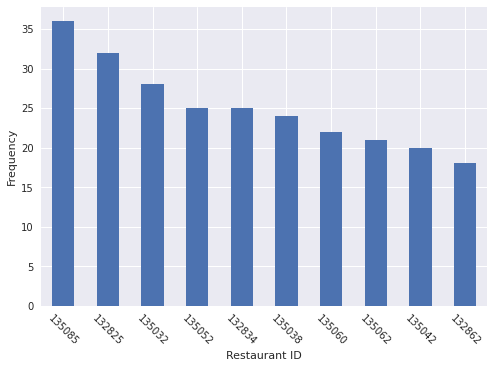

In [12]:
# Plot the above data
plt.style.use('seaborn')
placeID_grouped_data.iloc[ : 10]['rating'].plot(kind='bar')
plt.xlabel("Restaurant ID")
plt.ylabel("Frequency")
plt.xticks(rotation=-45)
#plt.grid()
plt.show()

In [13]:
# Top 10 restaurants having highest average overall ratings.
placeID_ratings_data = data.groupby('placeID').mean().sort_values(by='rating', ascending=False)
placeID_ratings_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132955,2.000000,1.800000,1.800000
135034,2.000000,2.000000,1.600000
134986,2.000000,2.000000,2.000000
132922,1.833333,1.500000,1.833333
132755,1.800000,2.000000,1.600000
135013,1.750000,2.000000,1.750000
134976,1.750000,1.750000,1.000000
135074,1.750000,1.750000,1.750000
135055,1.714286,1.714286,1.714286


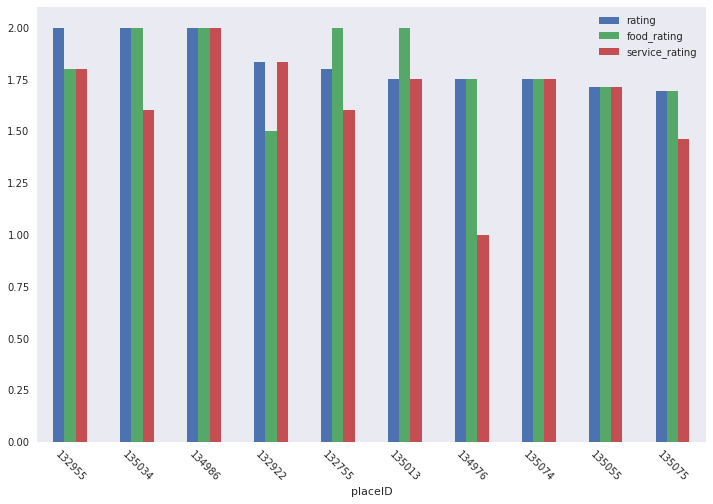

In [14]:
# Plot the above data
plt.style.use('seaborn')
placeID_ratings_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.grid()
plt.show()

In [15]:
# Restaurant: 134986 has the highest average overall rating, food_rating and service_rating.
rest_id = 134986
print("Restaurant with highest average overall rating, food_rating and service_rating is {}".format(data[data['placeID'] == rest_id]['name'].iloc[0]))

Restaurant with highest average overall rating, food_rating and service_rating is Restaurant Las Mananitas


**Restaurant: 134986 i.e Restaurant Las Mananitas has the highest average overall rating, food_rating and service_rating.**

In [16]:
# Top 10 restaurants having highest average food_rating ratings.
placeID_food_rating_data = data.groupby('placeID').mean().sort_values(by='food_rating', ascending=False)
placeID_food_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132667,1.250000,2.000000,1.250000
134986,2.000000,2.000000,2.000000
135034,2.000000,2.000000,1.600000
132755,1.800000,2.000000,1.600000
135013,1.750000,2.000000,1.750000
132955,2.000000,1.800000,1.800000
134976,1.750000,1.750000,1.000000
135074,1.750000,1.750000,1.750000
135018,1.500000,1.750000,1.500000


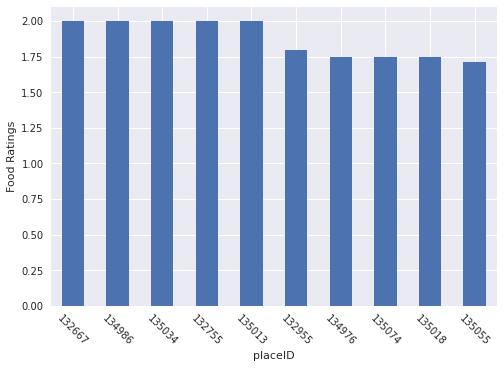

In [17]:
# Plot the above data
plt.style.use('seaborn')
placeID_food_rating_data['food_rating'].iloc[ : 10].plot(kind='bar')
plt.ylabel("Food Ratings")
plt.xticks(rotation=-45)
plt.show()

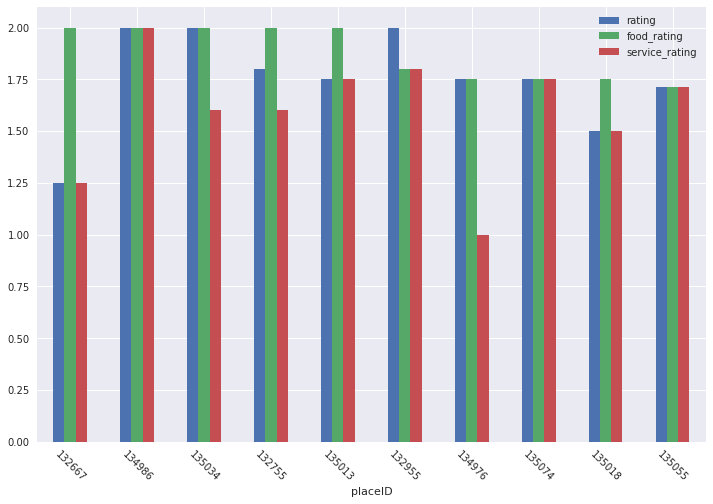

In [18]:
placeID_food_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.show()

In [19]:
print("Restaurant {} has an average food_rating of 2 which is max but it has low overal ratings and service_ratings.".format(data[data['placeID'] == 132667]['name'].iloc[0]))

Restaurant little pizza Emilio Portes Gil has an average food_rating of 2 which is max but it has low overal ratings and service_ratings.


**Restaurant 132667 (little pizza Emilio Portes Gil) has an average food_rating of 2 which is max but it has low overal ratings and service_ratings.**

In [20]:
# Top 10 restaurants having highest average service_rating ratings.
placeID_service_rating_data = data.groupby('placeID').mean().sort_values(by='service_rating', ascending=False)
placeID_service_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
134986,2.000000,2.000000,2.000000
132922,1.833333,1.500000,1.833333
132955,2.000000,1.800000,1.800000
135013,1.750000,2.000000,1.750000
135074,1.750000,1.750000,1.750000
132773,1.500000,1.250000,1.750000
135055,1.714286,1.714286,1.714286
134999,1.600000,1.600000,1.600000
135034,2.000000,2.000000,1.600000


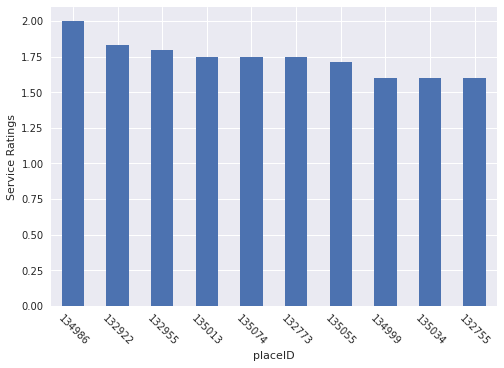

In [21]:
# Plot the above data
plt.style.use('seaborn')
placeID_service_rating_data['service_rating'].iloc[ : 10].plot(kind='bar')
plt.ylabel("Service Ratings")
plt.xticks(rotation=-45)
plt.show()

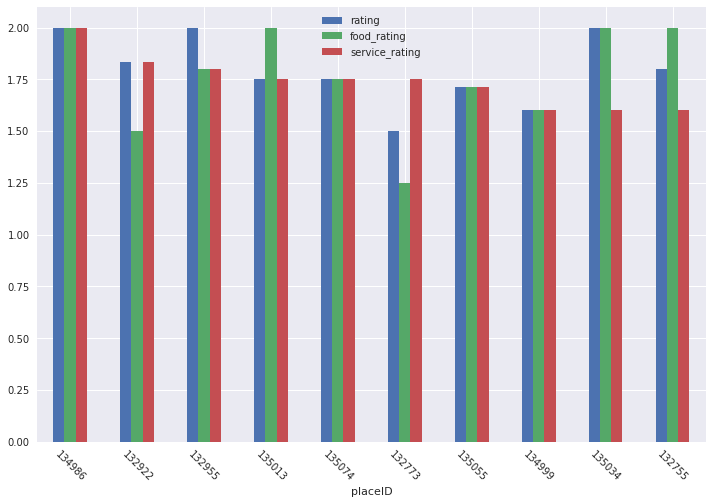

In [22]:
placeID_service_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.show()

In [23]:
# Top 10 least visited restaurants (occuring the least in the data).
placeID_rating_data = data.groupby('placeID').count().sort_values(by='rating')

In [24]:
placeID_rating_data.iloc[ : 10]

,userID,name,rating,food_rating,service_rating
placeID,,,,,
135011,3,3,3,3,3
132668,3,3,3,3,3
134975,3,3,3,3,3
132766,3,3,3,3,3
135016,3,3,3,3,3
132717,3,3,3,3,3
135033,4,4,4,4,4
135018,4,4,4,4,4
135040,4,4,4,4,4


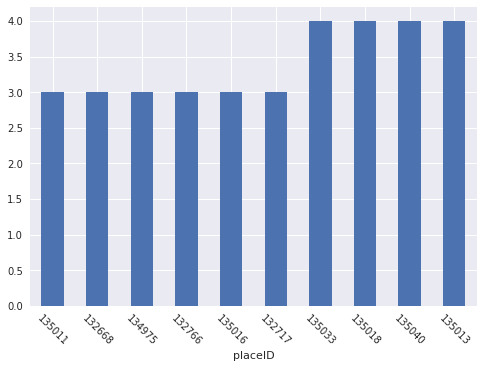

In [25]:
# Plot the above data
placeID_rating_data['rating'].iloc[ : 10].plot(kind='bar')
plt.xticks(rotation=-45)
plt.show()

**Restaurant IDs 135011, 132668, 134975 have the lowest occurences in the data.**

In [26]:
# Top 10 restaurants having lowest average overall ratings.
placeID_ratings_data = data.groupby('placeID').mean().sort_values(by='rating', ascending=True)
placeID_ratings_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132654,0.250,0.250,0.250000
135040,0.250,0.250,0.250000
132560,0.500,1.000,0.250000
132663,0.500,0.500,0.666667
135069,0.500,0.500,0.750000
132594,0.600,1.200,0.600000
132609,0.600,0.600,0.600000
132885,0.600,0.600,0.400000
132870,0.600,1.000,0.400000


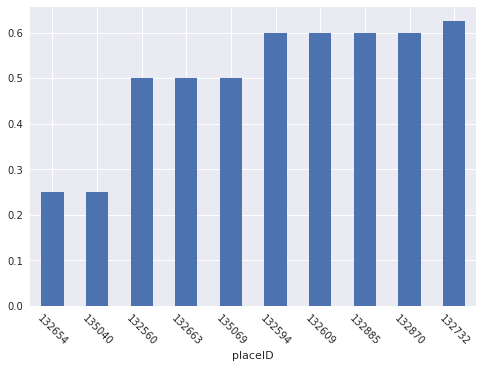

In [27]:
# Plot the above data
placeID_ratings_data['rating'].iloc[ : 10].plot(kind='bar')
plt.xticks(rotation=-45)
plt.show()

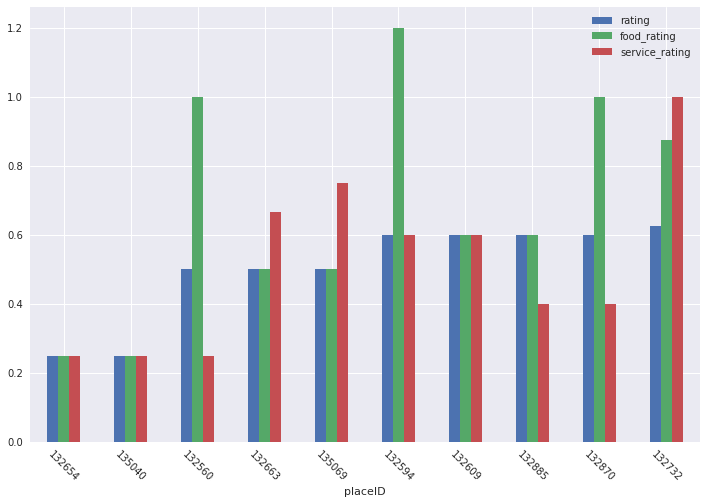

In [28]:
# Plot the above data
placeID_ratings_data.iloc[ : 10].plot(kind='bar', figsize=(12,8))
plt.xticks(rotation=-45)
plt.show()

In [29]:
# Top 10 restaurants having lowest average food_rating 
placeID_service_rating_data = data.groupby('placeID').mean().sort_values(by='food_rating', ascending=True)
placeID_service_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
135040,0.25,0.25,0.250000
132654,0.25,0.25,0.250000
134987,1.00,0.50,1.000000
132663,0.50,0.50,0.666667
135069,0.50,0.50,0.750000
135086,0.80,0.60,0.800000
132845,0.80,0.60,0.800000
132609,0.60,0.60,0.600000
135049,1.00,0.60,1.000000


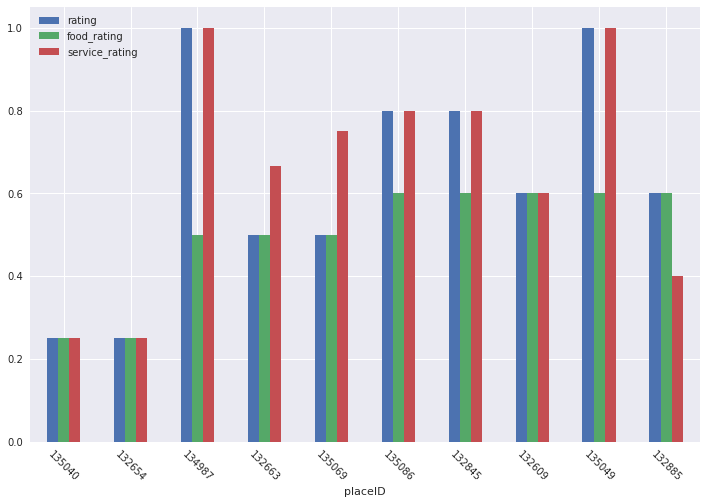

In [30]:
placeID_service_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=-45)
plt.show()

In [31]:
# Top 10 restaurants having lowest average service_rating ratings.
placeID_service_rating_data = data.groupby('placeID').mean().sort_values(by='service_rating', ascending=True)
placeID_service_rating_data.iloc[ : 10]

,rating,food_rating,service_rating
placeID,,,
132560,0.50,1.00,0.250
132654,0.25,0.25,0.250
135040,0.25,0.25,0.250
132870,0.60,1.00,0.400
132885,0.60,0.60,0.400
132715,1.00,1.00,0.500
132594,0.60,1.20,0.600
132609,0.60,0.60,0.600
132858,0.80,1.40,0.600


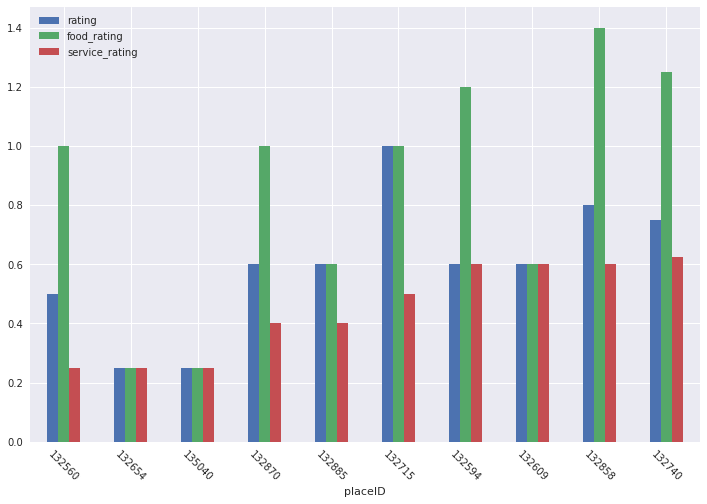

In [32]:
# Top 10 restaurants having lowest average service_rating ratings along with food_rating, service_rating
placeID_service_rating_data.iloc[ : 10].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=-45)
plt.show()

**Next plot top 10 userIDs i.e users which occur the most**

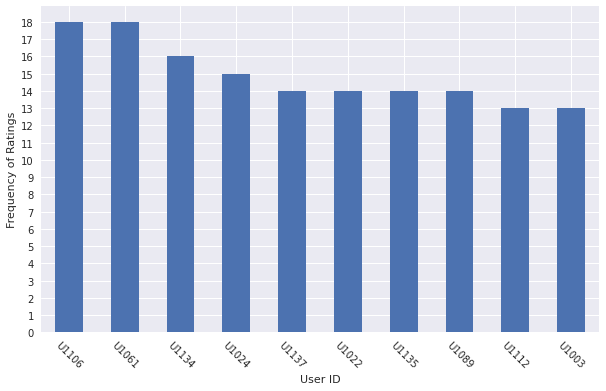

In [33]:
data.groupby('userID').count().sort_values(by='rating', ascending=False).iloc[ : 10]['rating'].plot(kind='bar', figsize=(10,6))
plt.xlabel("User ID")
plt.ylabel("Frequency of Ratings")
plt.xticks(rotation=-45)
plt.yticks(np.arange(0,19,1))
plt.show()

**User U1106 and U1061 occur the most of the times in the dataset i.e 18 times.**

In [34]:
data[['rating', 'food_rating', 'service_rating']].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


# Recommender Sytem

**1. Popularity Based Recommender System:**

It is a very fundamental type of recommender system which gives recommendations based on the popularity of the product. For example, the most popular product will be recommended first.

In [35]:
# Provide a score to each restaurant based on the count of their occurrence, i.e the place that occurs the most is more popular hence, scored high.
placeID_count = data.groupby('placeID').count()['userID'].to_dict()
data['placeScore'] = data['placeID'].map(placeID_count)

In [36]:
# generate top 10 recommendations
top_10_recommendations = pd.DataFrame(data['placeID'].value_counts()).reset_index().rename(columns = {'index' : 'placeID', 'placeID' : 'placeScore'}).iloc[ : 10]
top_10_recommendations = pd.merge(data[['placeID','name']], top_10_recommendations, on='placeID', how='right').drop_duplicates()

In [37]:
# Top 10 Recommendations
top_10_recommendations

,placeID,name,placeScore
0,135085,Tortas Locas Hipocampo,36
36,132825,puesto de tacos,32
68,135032,Cafeteria y Restaurant El Pacifico,28
96,135052,La Cantina Restaurante,25
121,132834,Gorditas Doa Gloria,25
146,135038,Restaurant la Chalita,24
170,135060,Restaurante Marisco Sam,22
192,135062,Restaurante El Cielo Potosino,21
213,135042,Restaurant Oriental Express,20
233,135058,Restaurante Tiberius,18


**2. Collaborative-Filtering:**


In general, collaborative filtering is a process of filtering information using techniques that involve multiple agents, viewpoint, data_sources etc. Specific to recommender systems, collaborative filtering is a technique to generate predictions about the interests/preferences of a user for a product based on the interests/preferences of other similar users.

The underlying assumption behind this concept is that if a person A has similar opinion as of a person B for a product, then it is very likely that A's opinion will be similar to that of B for some other product rather than that of a randomly chosen person.

In [38]:
# drop the placeScore
data.drop('placeScore', axis=1, inplace=True)

In [39]:
data.head()

,userID,placeID,name,rating,food_rating,service_rating
0,U1077,135085,Tortas Locas Hipocampo,2,2,2
1,U1108,135085,Tortas Locas Hipocampo,1,2,1
2,U1081,135085,Tortas Locas Hipocampo,1,2,1
3,U1056,135085,Tortas Locas Hipocampo,2,2,2
4,U1134,135085,Tortas Locas Hipocampo,2,1,2


In [40]:
# Create a reader object
reader = Reader(rating_scale=(0,2)) # The Reader class is used to parse a file containing ratings.
rating_data = Dataset.load_from_df(data[['userID', 'placeID', 'rating']], reader)

In [41]:
# using Singular Value Decomposition (Matrix Factorisation) to build the recommender system
svd = SVD(verbose=True, n_epochs=100)
svd_results = cross_validate(svd, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [42]:
svd_results

{'test_rmse': array([0.65241163, 0.65206459, 0.6741981 ]),
 'test_mae': array([0.53317187, 0.5303285 , 0.55654161]),
 'fit_time': (0.20531439781188965, 0.2041006088256836, 0.20993900299072266),
 'test_time': (0.014209270477294922,
  0.004778146743774414,
  0.013822317123413086)}

In [43]:
# SlopOne results
slope_one = SlopeOne()
slope_one_results = cross_validate(slope_one, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7478  0.7206  0.7579  0.7421  0.0157  
MAE (testset)     0.5590  0.5409  0.5699  0.5566  0.0119  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [44]:
slope_one_results

{'test_rmse': array([0.7478359 , 0.72059367, 0.7578671 ]),
 'test_mae': array([0.55897558, 0.54093603, 0.56985417]),
 'fit_time': (0.0028438568115234375,
  0.0028791427612304688,
  0.0028541088104248047),
 'test_time': (0.006306648254394531,
  0.005585670471191406,
  0.006272077560424805)}

In [45]:
# CoClustering
co_clustering = CoClustering(n_epochs=100, verbose=True, random_state=0)
co_clustering_results = cross_validate(co_clustering, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [46]:
co_clustering_results

{'test_rmse': array([0.7081581 , 0.69775309, 0.72244515]),
 'test_mae': array([0.51828457, 0.515731  , 0.54130971]),
 'fit_time': (0.2681713104248047, 0.2210230827331543, 0.16086935997009277),
 'test_time': (0.004067897796630859,
  0.001802206039428711,
  0.002110719680786133)}

In [47]:
# KNNBasic
knn_basic = KNNBasic(k=50)
knn_basic_results = cross_validate(knn_basic, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8333  0.8130  0.8472  0.8312  0.0141  
MAE (testset)     0.6889  0.6639  0.6989  0.6839  0.0147  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [48]:
#KNNWithMeans
knn_means = KNNWithMeans(k=100)
knn_means_results = cross_validate(knn_means, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7115  0.6834  0.6600  0.6850  0.0211  
MAE (testset)     0.5279  0.5065  0.4987  0.5110  0.0124  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [49]:
knn_means_results

{'test_rmse': array([0.71150158, 0.68343249, 0.66000615]),
 'test_mae': array([0.52789367, 0.50647892, 0.49865705]),
 'fit_time': (0.0034956932067871094,
  0.0031571388244628906,
  0.002978086471557617),
 'test_time': (0.013225555419921875,
  0.012157440185546875,
  0.012995481491088867)}

In [50]:
#KNNWithZScore
knn_zscore = KNNWithZScore(k=100)
knn_zscore_results = cross_validate(knn_zscore, rating_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6934  0.6971  0.6985  0.6963  0.0021  
MAE (testset)     0.5308  0.5245  0.5051  0.5201  0.0109  
Fit time          0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


In [51]:
np.array((svd_results['test_rmse'], 
 co_clustering_results['test_rmse'], 
 slope_one_results['test_rmse'],
 knn_basic_results['test_rmse'], 
 knn_means_results['test_rmse'], 
 knn_zscore_results['test_rmse']))

array([[0.65241163, 0.65206459, 0.6741981 ],
       [0.7081581 , 0.69775309, 0.72244515],
       [0.7478359 , 0.72059367, 0.7578671 ],
       [0.83331927, 0.81295091, 0.84723725],
       [0.71150158, 0.68343249, 0.66000615],
       [0.69339737, 0.69708389, 0.69847407]])

In [52]:
# Concat the results of all the models
results = np.array((svd_results['test_rmse'], 
                    co_clustering_results['test_rmse'], 
                    slope_one_results['test_rmse'],
                    knn_basic_results['test_rmse'], 
                    knn_means_results['test_rmse'], 
                    knn_zscore_results['test_rmse']))

result_df = pd.DataFrame(results, 
                         index=['SVD', 'CoClustering', 'SlopeOne', 'KNN_Basic', 'KNN_Means', 'KNN_ZScore'],
                         columns=['RMSE_fold_1','RMSE_fold_2','RMSE_fold_3'])

In [53]:
# Compute the mean RMSE score
result_df['Mean_RMSE'] = result_df[['RMSE_fold_1', 'RMSE_fold_2', 'RMSE_fold_3']].mean(axis=1)

In [54]:
result_df.sort_values(by='Mean_RMSE')

,RMSE_fold_1,RMSE_fold_2,RMSE_fold_3,Mean_RMSE
SVD,0.652412,0.652065,0.674198,0.659558
KNN_Means,0.711502,0.683432,0.660006,0.684980
KNN_ZScore,0.693397,0.697084,0.698474,0.696318
CoClustering,0.708158,0.697753,0.722445,0.709452
SlopeOne,0.747836,0.720594,0.757867,0.742099
KNN_Basic,0.833319,0.812951,0.847237,0.831169


**SVD performs the best amongst all.**

# Generate Recommendations using SVD

In [55]:
# 1. Get the restaurant id from restaurant name
def get_rest_id(rest_name, data):
    
    '''Returns the Restaurant ID (placeID) given the restaurant Name.'''
    
    rest_names = list(data['name'].values)
    
    # Using difflib find the restaurants that are closest to the input and extract the corresponding placeID
    
    closest_names = difflib.get_close_matches(rest_name, rest_names)
    rest_id = data[data['name'] == closest_names[0]]['placeID'].iloc[0]
    
    return rest_id

# 2. Predict the rating for this restaurant for a given user (b/w 0-2)
def predict_rating(user_id, rest_name, data, model=SVD):
    
    # extract the restaurant id from the restaurant name
    rest_id = get_rest_id(rest_name, data)
    #print(rest_id)
    
    # make predictions
    estimated_ratings = model.predict(uid = user_id, iid = rest_id)
    
    return estimated_ratings.est

# 3. Generate Recommendations for a given user

'''
In this, we will take userID as the input and output the names of all the restaurants for which the given user is most likely to
give a rating above a certain threshold rating (1.5 in this case).
'''
def recommend_restaurants(user_id, data=data, model=svd, threshold=1.5):
    
    # store the recommended restaurants along with the predicted ratings given by the user in a dictionary
    recommended_restaurants = {}
    
    # Find all the unique restaurant names
    unique_rest_names = list(np.unique(data['name'].values))
    
    # Shuffle the restaurant name list
    random.shuffle(unique_rest_names)
    
    # iterate over the list and generate ratings(predictions) for each restaurant and return only those which have a rating > threshold (1.5)
    for rest_name in unique_rest_names:
        
        # generate predictions
        #print(rest_name)
        rating = predict_rating(user_id=user_id, rest_name=rest_name, data=data, model=svd)
        
        # check if rating > threshold
        if rating > threshold:
            
            recommended_restaurants[rest_name] = np.round(rating,2)
    
    print("Generating Restaurant Recommendations for User ID {} : ".format(user_id))
    
    restaurant_names = np.array(list(recommended_restaurants.keys())).reshape(-1,1)
    restaurant_ratings = np.array(list(recommended_restaurants.values())).reshape(-1,1)
    
    results = np.concatenate((restaurant_names, restaurant_ratings), axis=1)
    results_df = pd.DataFrame(results, columns=['Restaurants', 'Rating (0-2)']).sort_values(by='Rating (0-2)', ascending=False)
    
    return results_df.reset_index().drop('index', axis=1)

In [56]:
# Randomly pick up a userID using np.random.choice
random_user_id = np.random.choice(list(np.unique(data['userID'].values)))

# Generate Recommendations for the user ID
recommend_restaurants(user_id = random_user_id)

Generating Restaurant Recommendations for User ID U1010 : 


,Restaurants,Rating (0-2)
0,Mariscos El Pescador,1.63
1,la Cochinita Pibil Restaurante Yucateco,1.57
2,dairy queen,1.52
3,La Estrella de Dimas,1.52
4,Dominos Pizza,1.5
